# Classification with a Convolutional Neural Network example

In this notebook, an example of classification using a CNN is given. For this, a dataset containing images of 12 different animals is used. The goal is to correctly predict the animal on an image.

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pprint
pp = pprint.PrettyPrinter(indent=4)

import joblib
from skimage.io import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
import skimage
from skimage.feature import hog
from sklearn.metrics import confusion_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable

data_path = r'C:\Users\main\Proton Drive\laurin.koller\My files\ML\repos\OrionML\Examples\example data\animal_face'

import numpy as np
import matplotlib.pyplot as plt

import os
os.chdir("C:\\Users\\main\\Proton Drive\\laurin.koller\\My files\\ML\\repos\\OrionML")

import OrionML as orn

### Load the data

To load the data, a pkl file should be created using the resize_all function in animal_faces_GDClassifier_example.py in the Examples directory. This file is now loaded. It contains data of the images, where all images were resized to be 80 by 80 pixels.

In [6]:
data = joblib.load(r"C:\Users\main\Desktop\ML\AnimalFace\pkl_files\animal_faces_80x80px.pkl")

labels = np.unique(data['label'])

An example image of each class is shown below.

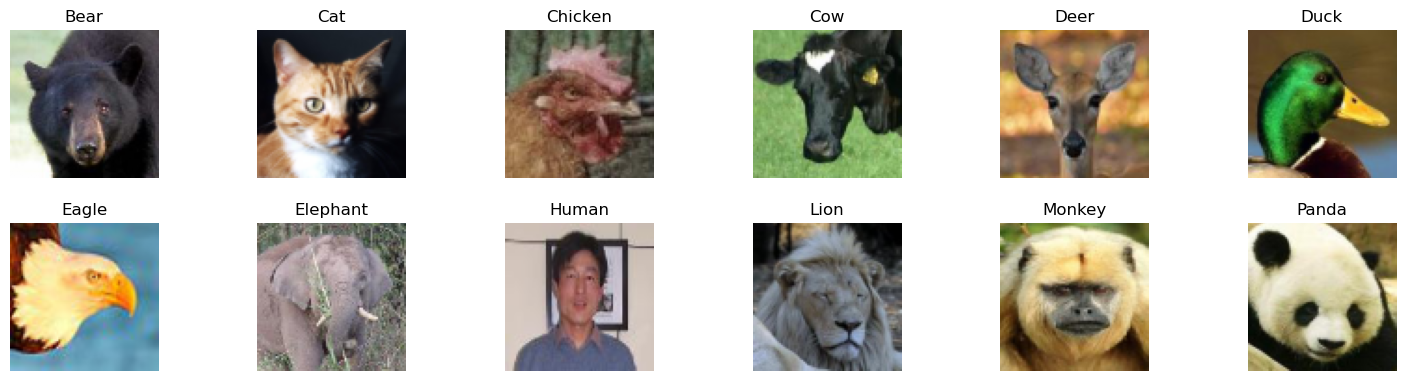

In [8]:
# set up the matplotlib figure and axes, based on the number of labels
fig, axes = plt.subplots(2, 6)
fig.set_size_inches(15,4)
fig.tight_layout()
 
# make a plot for every label (equipment) type. The index method returns the 
# index of the first item corresponding to its search string, label in this case
for ax, label in zip(axes.reshape(-1,), labels):
    idx = data['label'].index(label)
     
    ax.imshow(data['data'][idx])
    ax.axis('off')
    ax.set_title(label)
plt.show()

The data is now split into a training and a test set. The test set contains 20% of the images. Following this, a Standard scaler is fit to the training data and both the train and test data are transformed using this scaler.

In [12]:
X = np.array(data['data'])
y = np.array(data['label'])

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    shuffle=True,
    random_state=0
)

scaler = orn.utils.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

The labels for the training and test set are currently given as a string, but they need to be in the form of one-hot vectors.

In [16]:
def arr_one(pos):
    arr = np.zeros(len(labels))
    arr[pos] = 1
    return arr

one_hot_map = {labels[i]: arr_one(i) for i in range(len(labels))}

y_traino = np.array([one_hot_map.get(val) for val in y_train])
y_testo = np.array([one_hot_map.get(val) for val in y_test])

Below, a histogram showing the ratio of each class from all samples for the training and the test set can be seen.

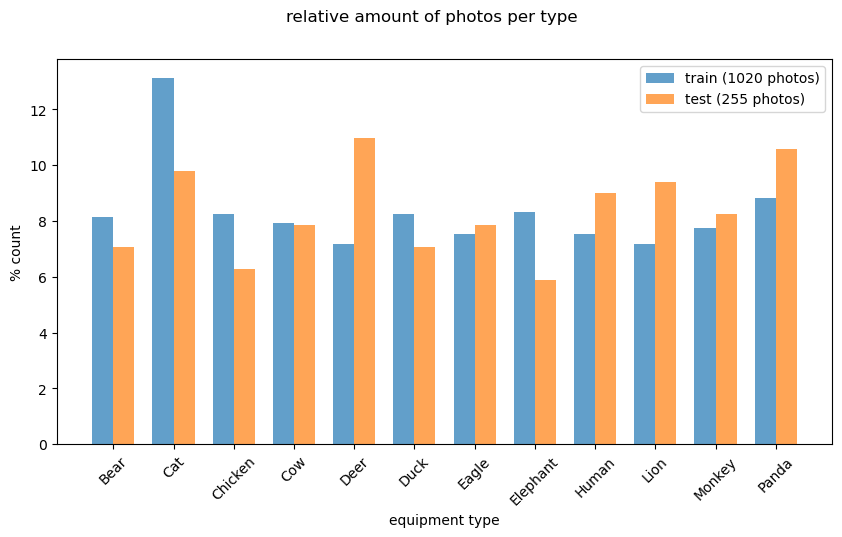

In [19]:
def plot_bar(y, loc='left', relative=True):
    width = 0.35
    if loc == 'left':
        n = -0.5
    elif loc == 'right':
        n = 0.5
     
    # calculate counts per type and sort, to ensure their order
    unique, counts = np.unique(y, return_counts=True)
    sorted_index = np.argsort(unique)
    unique = unique[sorted_index]
     
    if relative:
        # plot as a percentage
        counts = 100*counts[sorted_index]/len(y)
        ylabel_text = '% count'
    else:
        # plot counts
        counts = counts[sorted_index]
        ylabel_text = 'count'
         
    xtemp = np.arange(len(unique))
     
    plt.bar(xtemp + n*width, counts, align='center', alpha=.7, width=width)
    plt.xticks(xtemp, unique, rotation=45)
    plt.xlabel('equipment type')
    plt.ylabel(ylabel_text)

plt.figure(figsize=(10,5))
plt.suptitle('relative amount of photos per type')
plot_bar(y_train, loc='left')
plot_bar(y_test, loc='right')
plt.legend([
    'train ({0} photos)'.format(len(y_train)), 
    'test ({0} photos)'.format(len(y_test))
]);
plt.show()


# Defining and Training the model

Now, the model architecture and some parameters of the model can be defined can be defined.

In [22]:
seq = orn.Sequential([orn.Layer.Conv(3, 6, 5, stride=2, activation="relu"), orn.Layer.Pool(2, 2, pool_mode="max"), orn.Layer.Dropout(0.3),
                      orn.Layer.Conv(6, 12, 5, stride=2, activation="relu"), orn.Layer.Pool(2, 2, pool_mode="max"), orn.Layer.Dropout(0.3),
                      orn.Layer.Flatten(), orn.Layer.Linear(192, 12, "softmax")], 
                     initializer="he")

nn = orn.NeuralNetwork(seq, optimizer="adam", loss="cross_entropy", learning_rate=1e-4, verbose=10)

In [32]:
seq = orn.Sequential([orn.Layer.Conv(3, 6, 4, stride=2, activation="relu"), orn.Layer.Dropout(0.3), #orn.Layer.BatchNorm2D(6),
                      orn.Layer.Conv(6, 12, 5, stride=3, activation="relu"), #orn.Layer.Dropout(0.3), #orn.Layer.BatchNorm2D(12),
                      orn.Layer.Flatten(), orn.Layer.Dropout(0.3), orn.Layer.Linear(768, 12, "softmax")], 
                     initializer="he")

nn = orn.NeuralNetwork(seq, optimizer="adam", loss="cross_entropy", learning_rate=1e-3, verbose=10)

In [125]:
seq = orn.Sequential([orn.Layer.Conv(3, 6, 4, stride=2, activation="relu"), orn.Layer.Dropout(0.3), #orn.Layer.BatchNorm2D(6),
                      orn.Layer.Conv(6, 9, 4, stride=2, activation="relu"), #orn.Layer.Dropout(0.3), #orn.Layer.BatchNorm2D(12),
                      orn.Layer.Conv(9, 12, 3, stride=2, activation="relu"),
                      orn.Layer.Flatten(), orn.Layer.Linear(768, 12, "softmax")], 
                     initializer="he")

nn = orn.NeuralNetwork(seq, optimizer="adam", loss="cross_entropy", learning_rate=1e-4, verbose=20)

In [127]:
nn.fit(X_train, y_traino, epochs=500, validation=[X_test, y_testo], batch_size=32)

Iteration    1:
Training   Loss:    33.63, accuracy 8.7%.
Validation Loss:    33.23, accuracy 9.8%.

Iteration   25:
Training   Loss:    32.54, accuracy 11.7%.
Validation Loss:    32.51, accuracy 11.8%.

Iteration   50:
Training   Loss:     32.0, accuracy 13.1%.
Validation Loss:    32.07, accuracy 12.9%.

Iteration   75:
Training   Loss:    29.73, accuracy 19.3%.
Validation Loss:    29.47, accuracy 20.0%.

Iteration  100:
Training   Loss:    27.31, accuracy 25.9%.
Validation Loss:    27.88, accuracy 24.3%.

Iteration  125:
Training   Loss:    24.09, accuracy 34.6%.
Validation Loss:    24.85, accuracy 32.5%.

Iteration  150:
Training   Loss:     20.7, accuracy 43.8%.
Validation Loss:    24.85, accuracy 32.5%.

Iteration  175:
Training   Loss:    19.43, accuracy 47.3%.
Validation Loss:    22.25, accuracy 39.6%.

Iteration  200:
Training   Loss:    16.51, accuracy 55.2%.
Validation Loss:    21.09, accuracy 42.7%.

Iteration  225:
Training   Loss:    15.03, accuracy 59.2%.
Validation Loss:

In [100]:
np.sum(nn.times)

214.113511800766

In [44]:
(80-4)//2 + 1, (39-4)//2 + 1, (18-3)//2 + 1, 8**2 * 12

(39, 18, 8, 768)

The model is trained using gradient descent.

In [44]:
np.random.seed(0)
pred_test = np.array([np.random.multinomial(1,val) for val in seq(X_test)])
same_arr_test = np.array([np.array_equal(y_testo[i], pred_test[i]) for i in range(len(y_testo))])
acc_test = np.sum(same_arr_test)/len(y_testo)

pred_train = np.array([np.random.multinomial(1,val) for val in seq(X_train)])
same_arr_train = np.array([np.array_equal(y_traino[i], pred_train[i]) for i in range(len(y_traino))])
acc_train = np.sum(same_arr_train)/len(y_traino)
    
print(f"Training:   Loss {orn.Loss.cross_entropy().value(y_traino, pred_train):8.4}, accuracy {100*acc_train:2.1f}%.")
print(f"Validation: Loss {orn.Loss.cross_entropy().value(y_testo, pred_test):8.4}, accuracy {100*acc_test:2.1f}%.\n")

Training:   Loss   0.1806, accuracy 99.5%.
Validation: Loss    17.92, accuracy 51.4%.



In [38]:
pred_test[0], y_testo[0]

(array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]),
 array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]))

In [42]:
np.array_equal(pred_test[0], y_testo[0])

True

In [37]:
(80-5)//2 + 1, (38-2)//2 + 1, (19-5)//2 + 1, (8-2)//2 + 1

(38, 19, 8, 4)

In [39]:
4**2 * 12

192

In [333]:
seq = orn.Sequential([orn.Layer.Linear(784, 10, activation="softmax")])

nn = orn.NeuralNetwork(seq, learning_rate=1e-1)

nn.fit(train_X, train_y, epochs=10, batch_size=10000)

Iteration    0: Cost      nan, params:   nan,   nan
Iteration    1: Cost      nan, params:   nan,   nan
Iteration    2: Cost      nan, params:   nan,   nan
Iteration    3: Cost      nan, params:   nan,   nan
Iteration    4: Cost      nan, params:   nan,   nan


KeyboardInterrupt: 

Now the training data can be used to train the model.

In [329]:
nn.fit(train_X, train_y, epochs=100, batch_size=None)

C:\Users\main\Proton Drive\laurin.koller\My files\ML\repos\OrionML\OrionML\activation.py:293: RuntimeWarning: overflow encountered in exp
  return np.exp(z)/np.sum(np.exp(z), axis=1, keepdims=True)
C:\Users\main\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\main\Proton Drive\laurin.koller\My files\ML\repos\OrionML\OrionML\activation.py:293: RuntimeWarning: invalid value encountered in divide
  return np.exp(z)/np.sum(np.exp(z), axis=1, keepdims=True)


Iteration    0: Cost      nan, params:   nan,   nan
Iteration   10: Cost      nan, params:   nan,   nan


KeyboardInterrupt: 

In [327]:
train_y

array([[5],
       [0],
       [4],
       ...,
       [5],
       [6],
       [8]], dtype=int64)